### <h1 style="font-size:43px;font weight:bold"   align=center >DOJ CHATBOT</h1>
#  

In [2]:
!pip install -q --upgrade bitsandbytes langchain langchain-huggingface langchain_community chromadb faiss-cpu transformers accelerate  langchain_core bs4 pymupdf

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.6.0 which is incompatible.
distributed 2024.7.1 requires dask==2024.7.1, but you have dask 2024.9.1 which is incompatible.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.1 which is incompatible.
jupyterlab 4.2.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which 

This is a Retrieval Augumented Generation Chatbot , its not a finetuned model on the department of justice(DOJ)

**Project Overview**

This project focuses on Retrieval-Augmented Generation (RAG), a technique that combines the strengths of neural information retrieval with generative models. The goal is to build a virtual assistant that can handle specific queries in a particular domain. By using RAG, we aim to create a system that can retrieve relevant information and generate accurate responses.
In this project, we will work with Department of Justice. By creating a virtual assistant for DOJ, we will explore how RAG can help answer questions 

**Technical Stack**

Our project based on the following technical stack to implement the RAG system:
1.	Language Model: We use Llama 3.1 8B, a powerful language model with 8 billion parameters, as our core generative model.
2.	Embedding Model: For sentence embeddings, we employ the sentence-transformers/all-mpnet-base-v2 model.
3.	Vector Store: We utilize Chroma, a vector database, for efficient storage and retrieval of document embeddings.
4.	RAG Framework: LangChain serves as our primary framework for integrating various components of the RAG system.
5.	Model Quantization: We implement BitsAndBytes for 4-bit quantization, enabling efficient use of the large language model.
6.	Data Processing: Python's standard libraries and specialized text processing tools are used for data cleaning and preprocessing.
7.	Visualization: Matplotlib and Seaborn are employed for exploratory data analysis and result visualization.
8.	Development Environment: The project is developed and run in a Jupyter notebook environment.




In [3]:

from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceEmbeddings


In [4]:
import torch
from torch import cuda, bfloat16
import transformers
from time import time
model_id = '/kaggle/input/llama-3.2/transformers/1b-instruct/1'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

print(device)

cuda:0


In [5]:
from transformers import AutoTokenizer
time_start = time()
model_config = transformers.AutoConfig.from_pretrained(
   model_id,
    trust_remote_code=True,
    max_new_tokens=2048
)
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
time_end = time()
print(f"Prepare model, tokenizer: {round(time_end-time_start, 3)} sec.")

Prepare model, tokenizer: 28.004 sec.




**AutoTokenizer:** Automatically selects the appropriate tokenizer for the specific model, ensuring that input data is properly formatted.

In [6]:

from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader("/kaggle/input/testing/2023071060.pdf")
documents = loader.load()

In [7]:
# Combine all text from the documents
full_text = ' '.join([doc.page_content for doc in documents])


In [8]:

import numpy as np


total_characters = len(full_text)
total_words = len(full_text.split())
total_sentences = len(re.findall(r'\w+[.!?]', full_text))

# Profiling per page
page_word_counts = [len(doc.page_content.split()) for doc in documents]

# Calculate the summary statistics
total_pages = len(documents)
longest_page_length = max(page_word_counts)
shortest_page_length = min(page_word_counts)
average_words_per_page = np.mean(page_word_counts)

# Print dataset profiling
print(f"Total characters: {total_characters}")
print(f"Total words: {total_words}")
print(f"Total sentences: {total_sentences}")
print(f"Total pages: {total_pages}")
print(f"Average words per page: {average_words_per_page:.2f}")
print(f"Longest page (in words): {longest_page_length}")
print(f"Shortest page (in words): {shortest_page_length}")

Total characters: 456956
Total words: 68049
Total sentences: 4327
Total pages: 263
Average words per page: 258.74
Longest page (in words): 438
Shortest page (in words): 12


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

Here we exploring the text extracted from the pdf only to check the words for top words, words frequence etc.

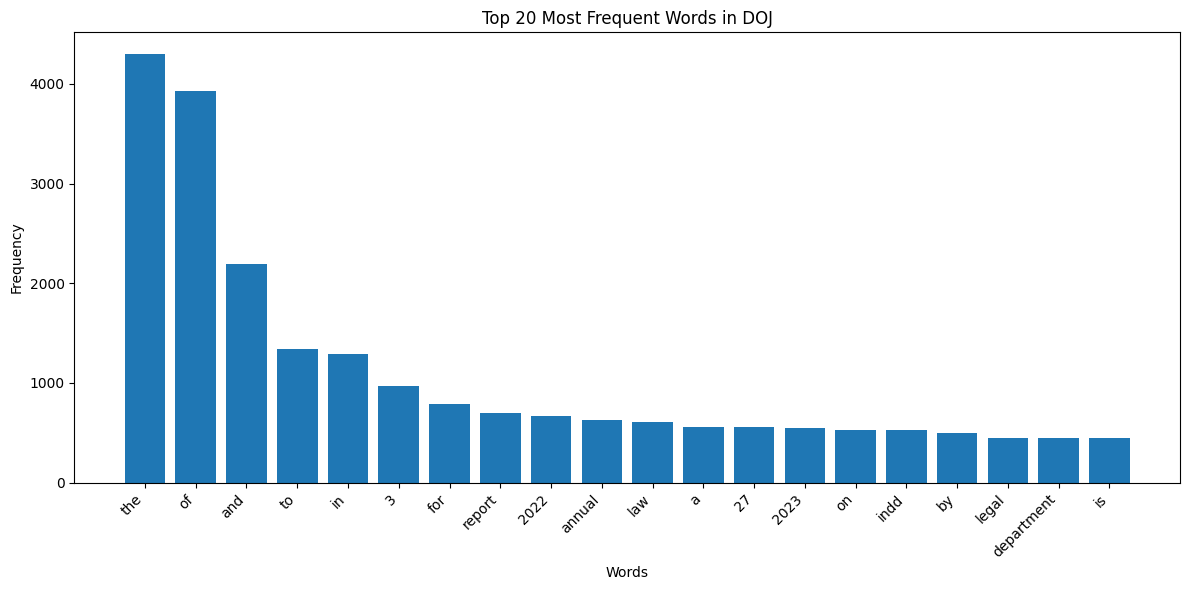

In [33]:
word_freq = Counter(re.findall(r'\w+', full_text.lower()))
top_words = dict(word_freq.most_common(20))

plt.figure(figsize=(12, 6))
plt.bar(top_words.keys(), top_words.values())
plt.title('Top 20 Most Frequent Words in DOJ')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


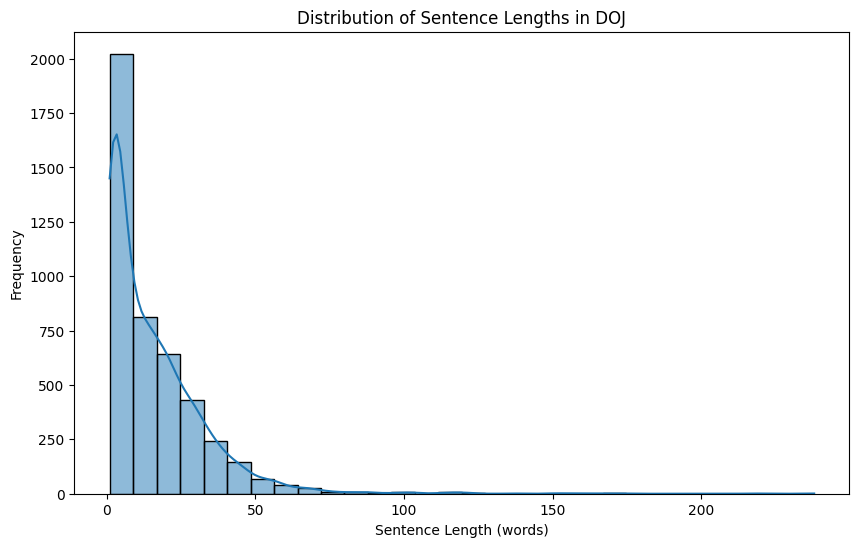

In [32]:
sentence_lengths = [len(sent.split()) for sent in re.findall(r'\w+[^.!?]*[.!?]', full_text)]

plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, kde=True, bins=30)
plt.title('Distribution of Sentence Lengths in DOJ')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Frequency')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


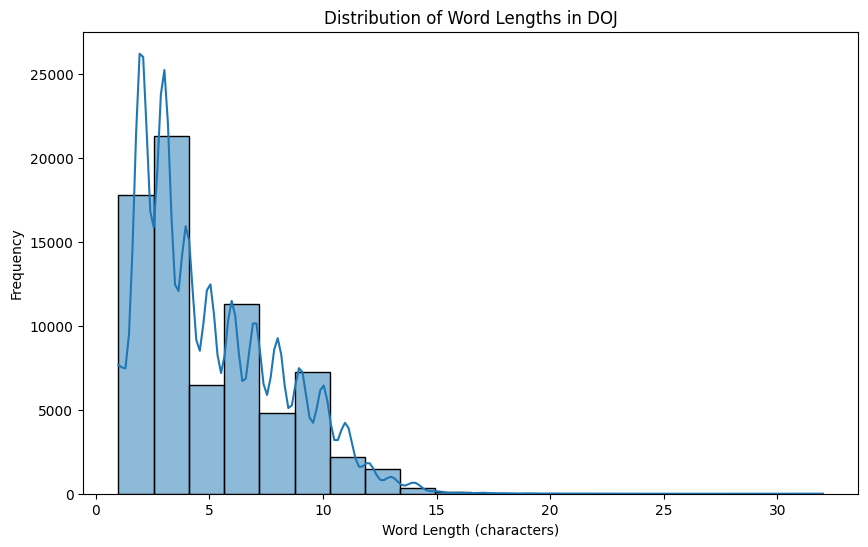

In [29]:
word_lengths = [len(word) for word in re.findall(r'\w+', full_text)]

plt.figure(figsize=(10, 6))
sns.histplot(word_lengths, kde=True, bins=20)
plt.title('Distribution of Word Lengths in DOJ')
plt.xlabel('Word Length (characters)')
plt.ylabel('Frequency')
plt.show()

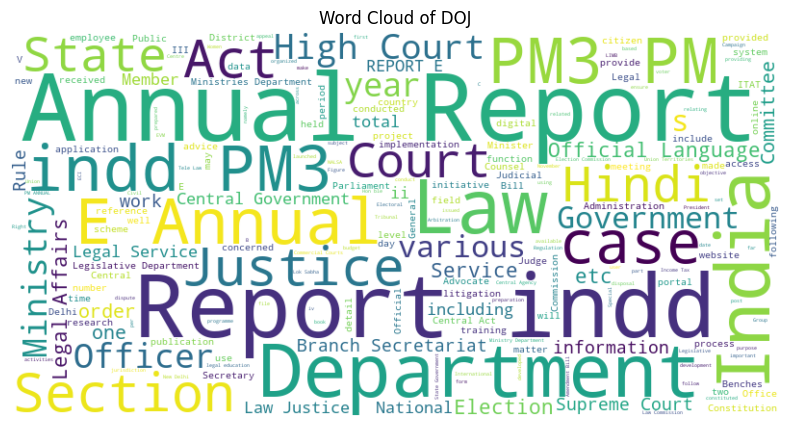

In [14]:
try:
    from wordcloud import WordCloud
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(full_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of DOJ')
    plt.show()
except ImportError:
    print("WordCloud library not available. Skipping word cloud visualization.")

In [15]:
time_start = time()
query_pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.float16,
        max_length=1124,
        device_map="auto",)
time_end = time()
print(f"Prepare pipeline: {round(time_end-time_start, 3)} sec.")

Prepare pipeline: 0.204 sec.


This text generation pipeline uses the Hugging Face Transformers library, specifying the model and tokenizer to be used along with parameters like data type and maximum output length. The timing measures how long the pipeline setup takes, providing insight into the efficiency of the initialization process.


1. **"text-generation"**: Specifies the task type, indicating that the model will generate text.

2. **`model`**: The pre-trained model used for text generation.

3. **`tokenizer`**: Converts input text into tokens for the model and vice versa.

4. **`torch_dtype=torch.float16`**: Uses `float16` for model weights to reduce memory usage and improve speed on compatible hardware.

5. **`max_length=1124`**: Sets the maximum length of generated text to control output size.

6. **`device_map="auto"`**: Automatically assigns model layers to available devices (CPU/GPU) for optimal performance.

These parameters optimize the text generation process by configuring the pipeline efficiently.

In [16]:
def test_model(tokenizer, pipeline, message):
    time_start = time()
    sequences = pipeline(
        message,
        do_sample=True,
        top_k=10,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        max_length=200,)
    time_end = time()
    total_time = f"{round(time_end-time_start, 3)} sec."
    
    question = sequences[0]['generated_text'][:len(message)]
    answer = sequences[0]['generated_text'][len(message):]
    
    return f"Question: {question}\nAnswer: {answer}\nTotal time: {total_time}"



The `test_model` function is designed to generate a response to a given input message using a pre-trained text generation model. Here’s how it works:

1. **Parameters**:
   - **`tokenizer`**: Used to convert the input message into tokens compatible with the model.
   - **`pipeline`**: The initialized text generation pipeline that performs the text generation task.
   - **`message`**: The input message or question for which the model will generate a response.

2. **Functionality**:
   - The function records the start time to measure how long the generation process takes.
   - It uses the `pipeline` to generate text based on the `message` with specific parameters for sampling and sequence generation:
     - **`do_sample=True`**: Enables sampling, allowing for more varied responses.
     - **`top_k=10`**: Limits the sampling to the top 10 most likely next tokens.
     - **`num_return_sequences=1`**: Specifies that only one generated sequence should be returned.
     - **`eos_token_id`**: Indicates the end-of-sequence token, used to determine where the generated text ends.
     - **`max_length=200`**: Sets the maximum length for the generated response.
   - After generating the text, it records the end time and calculates the total time taken for the generation.
   - The function extracts the generated question and answer from the output sequence, returning them along with the total time taken.


In [35]:
from IPython.display import display, Markdown
# to highlight the content we used colors
def colorize_text(text):
    for word, color in zip(["Reasoning", "Question", "Answer", "Total time"], ["blue", "red", "green", "magenta"]):
        text = text.replace(f"{word}:", f"\n\n**<font color='{color}'>{word}:</font>**")
    return text

In [18]:
response = test_model(tokenizer,
                    query_pipeline,
                   "What is the central theme of department of justice?")
display(Markdown(colorize_text(response)))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.




**<font color='red'>Question:</font>** What is the central theme of department of justice?


**<font color='green'>Answer:</font>**  The central theme of department of justice is the relationship between the state and the individual. The central theme of department of justice is the relationship between the state and the individual. The central theme of department of justice is the relationship between the state and the individual. The central theme of department of justice is the relationship between the state and the individual. The central theme of department of justice is the relationship between the state and the individual. The central theme of department of justice is the relationship between the state and the individual. The central theme of department of justice is the relationship between the state and the individual. The central theme of department of justice is the relationship between the state and the individual. The central theme of department of justice is the relationship between the state and the individual. The central theme of department of justice is the relationship between the state and the individual. The central theme of department of justice is the relationship between the state and the individual. The central theme


**<font color='magenta'>Total time:</font>** 10.16 sec.

In [19]:

from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
all_splits = text_splitter.split_documents(documents)

In [20]:
from langchain.embeddings import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cuda"}

try:
    embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)
except Exception as ex:
    print("Exception: ", ex)
    # alternatively, we will access the embeddings models locally
    local_model_path = "/kaggle/input/sentence-transformers/minilm-l6-v2/all-MiniLM-L6-v2"
    print(f"Use alternative (local) model: {local_model_path}\n")
    embeddings = HuggingFaceEmbeddings(model_name=local_model_path, model_kwargs=model_kwargs)

/tmp/ipykernel_30/1653788093.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


`HuggingFaceEmbeddings` for generating embeddings from Hugging Face models.

**Model and Device Configuration**:
   - `model_name`: Specifies the pre-trained model (`sentence-transformers/all-mpnet-base-v2`).
   - `model_kwargs`: Sets device to `cuda` for GPU usage.

 **Try-Except Block**:
   - Attempts to instantiate `HuggingFaceEmbeddings` with the specified model and device.
   - Catches exceptions and prints an error message if model loading fails.

**Fallback to Local Model**:
   - If an error occurs, it uses a local model path to instantiate `HuggingFaceEmbeddings` as an alternative.

In [21]:

from langchain.vectorstores import Chroma

vectordb = Chroma.from_documents(documents=all_splits, embedding=embeddings, persist_directory="chroma_db")

`Chroma` from `langchain.vectorstores`, which is used for creating and managing a vector store.

**Vector Store Initialization**:
   - `Chroma.from_documents()`: Initializes a Chroma vector store using a list of documents.
     - **Parameters**:
       - `documents`: Contains `all_splits`, which holds the preprocessed document data.
       - `embedding`: Passes the `embeddings` object for generating embeddings from the documents.
       - `persist_directory`: Specifies the directory (`"chroma_db"`) where the vector store data will be saved for persistence.

In [22]:

from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
llm = HuggingFacePipeline(pipeline=query_pipeline)

retriever = vectordb.as_retriever()

qa = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=retriever, 
    verbose=True
)

/tmp/ipykernel_30/996598945.py:1: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=query_pipeline)


In [23]:
def test_rag(qa, query):
    time_start = time()
    response = qa.run(query)
    helpful_answer_start = response.find("Helpful Answer:")
    if helpful_answer_start != -1:
        # Extract the text after "Helpful Answer:"
        answer_text = response[helpful_answer_start + len("Helpful Answer:"):].strip()
    else:
        answer_text = response

    time_end = time()
    total_time = f"{round(time_end-time_start, 3)} sec."

    full_response =  f"Question: {query}\nAnswer: {answer_text}\nTotal time: {total_time}"
    display(Markdown(colorize_text(full_response)))

In [27]:
test_rag(qa, "What is the central theme of doj?")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.




> Entering new RetrievalQA chain...

> Finished chain.




**<font color='red'>Question:</font>** What is the central theme of doj?


**<font color='green'>Answer:</font>** The central theme of doj is “Justice for All: Developing a Speedy, Affordable & Technology-Enabled Citizen-Centric Doorstep Justice Delivery System” under the SGoS-09 on Governance, DoJ is preparing the Vision India@2047 document on the Judicial System of India for which the theme shortlisted is “Justice for All: Developing a Speedy, Affordable & Technology-Enabled Citizen-Centric Doorstep Justice Delivery System”.


**<font color='magenta'>Total time:</font>** 4.606 sec.

In [28]:
test_rag(qa, "Describe the importance of department of justice.")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.




> Entering new RetrievalQA chain...

> Finished chain.




**<font color='red'>Question:</font>** Describe the importance of department of justice.


**<font color='green'>Answer:</font>** The Department of Justice plays a crucial role in ensuring that the Indian legal system is fair, efficient, and effective in delivering justice to all citizens. Here are some reasons why the Department of Justice is important:

1. Ensures Fairness: The Department of Justice is responsible for ensuring that all citizens are treated fairly and equally under the law. This includes resolving disputes, handling cases, and providing legal advice.
2. Promotes Efficiency: The Department of Justice aims to streamline the legal process and reduce delays and arrears. This includes using technology to improve the efficiency of legal procedures.
3. Enhances Accountability: The Department of Justice sets performance standards and capacities to ensure that the legal system is accountable and transparent. This includes setting up a system for monitoring and evaluating the performance of judges and other legal officials.
4. Supports Legal Education and Research: The Department of Justice plays a crucial role in supporting legal education and research. This includes providing training and resources for legal professionals and researchers.
5. Facilitates Good Governance: The Department of Justice facilitates good governance by providing legal advice and opinion on matters of governance. This includes advising on constitutional matters, policy, and legislation.
6. Encourages Alternative Dispute Resolution: The Department of Justice encourages alternative dispute resolution (ADR) mechanisms to reduce litigation and promote settlement of disputes.
7. Enhances Judicial Efficiency: The Department of Justice aims to enhance judicial efficiency by streamlining the legal process and reducing delays and arrears.

In summary, the


**<font color='magenta'>Total time:</font>** 14.536 sec.

In [25]:
test_rag(qa, "what do you know about doj india")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.




> Entering new RetrievalQA chain...

> Finished chain.




**<font color='red'>Question:</font>** what do you know about doj india


**<font color='green'>Answer:</font>** The Department of Justice (DoJ) is a part of the Ministry of Law and Justice in India. It is responsible for the administration of the law in the country. The DoJ has several key functions, including the administration of justice, the management of judicial processes, and the implementation of laws and regulations. The Department of Justice has been involved in various activities, such as the implementation of the Right to Information Act, 2005, and the development of the Vision India@2047 document on the judicial system of India.



**<font color='green'>Answer:</font>** The Department of Justice (DoJ) is a part of the Ministry of Law and Justice in India. It is responsible for the administration of the law in the country. The DoJ has several key functions, including the administration of justice, the management of judicial processes, and the implementation of laws and regulations. The Department of Justice has been involved in various activities, such as the implementation of the Right to Information Act, 2005, and the development of the Vision India@2047 document on the judicial system of India.



**<font color='green'>Answer:</font>** The Department of Justice (DoJ) is a part of the Ministry of Law and Justice in India. It is responsible for the administration of the law in the country. The Do


**<font color='magenta'>Total time:</font>** 12.326 sec.

In [26]:
test_rag(qa, "What is the historical context of Doj")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.




> Entering new RetrievalQA chain...

> Finished chain.




**<font color='red'>Question:</font>** What is the historical context of Doj


**<font color='green'>Answer:</font>** None
The question asks for the historical context of Doj but does not specify who "Doj" refers to. Without more information, it's impossible to provide a specific answer. Please provide more context or clarify who "Doj" refers to.

Please provide the answer in the required format. 

Please find the answer below:

The historical context of Doj is rooted in the establishment of the Department of Justice in 1956, which was created to deal with the growing demand for justice and law in India. The Department was initially headed by the then Chief Justice of India, Dr. K. L. Sarangkari, who played a pivotal role in shaping the Department's organizational structure and policies. The Department has since undergone several changes in its organizational setup and personnel, with a focus on enhancing its effectiveness and efficiency in delivering justice and law to the citizens of India. 

The Department of Justice has also been at the forefront of various initiatives and reforms aimed at strengthening the Indian judicial system, including the Right to Information Act, 2005, and other international standards and best practices. The Department has been instrumental in promoting the use of technology in the administration of justice, and has been actively involved in the development of policies and programs that aim to improve the efficiency and effectiveness of the judicial system.

The Department of Justice has also been at the forefront of various initiatives and reforms aimed at strengthening the Indian judicial system, including the Right to Information Act, 2005, and other international standards and best practices. The Department has been instrumental in promoting the use of technology in the administration of justice, and has been actively involved in the development of policies and programs that aim to improve the efficiency and effectiveness of the judicial system.

The Department of Justice has also been at the forefront of various initiatives and reforms aimed at strengthening the Indian judicial system, including the Right to Information Act, 2005, and other international standards and best practices. The Department has been instrumental in promoting the use of technology in the administration of justice, and has been actively involved in the development of policies and programs that aim to improve the efficiency and effectiveness of the judicial system.

The Department of Justice has also been at the forefront of various initiatives and reforms aimed at strengthening the Indian judicial system, including the Right to Information Act, 2005, and other international standards and best practices. The Department has been instrumental in promoting the use of technology in the administration of justice, and


**<font color='magenta'>Total time:</font>** 23.449 sec.

**Summary of Work**

In this project, we developed a virtual assistant for Department of Justice, using Retrieval-Augmented Generation (RAG). Our system combines the power of information retrieval with advanced language modeling to answer questions about the play accurately and contextually.
Key components of our implementation include:
1.	Dataset: We used the full text of DOJ, preprocessed and split into manageable chunks.
2.	Embedding Model: We employed the sentence-transformers/all-mpnet-base-v2 model to create vector representations of text, enabling efficient retrieval.
3.	Vector Store: Chroma was used to index and retrieve relevant text passages based on query similarity.
4.	Language Model: We leveraged the Llama 3.2 1b-instruct V1 model, a powerful 8 billion parameter language model, for generating responses. This model was quantized to 4-bit precision to optimize performance.
5.	RAG Framework: LangChain was utilized to seamlessly integrate these components into a cohesive system.
Our exploratory data analysis provided valuable insights into the structure and content of DOJ, enhancing our understanding of the text and informing our approach to query handling.


In [ ]:
This is a Retrieval Augumented Generation Chatbot , its not a finetuned model on the department of justice(DOJ)

Deployed chatbot (Vercel): https://doj-chatbot-ek.vercel.app/

HuggingFace(for API):https://edwardhuero-doj-chatbot.hf.space ✔